# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)

In [2]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')

except:
    df = pd.read_csv('users_behavior.csv')

In [3]:
display(df.head(), df.sample(5), df.tail())

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


,calls,minutes,messages,mb_used,is_ultra
1432,53.0,385.24,34.0,17383.22,0
411,1.0,1.78,38.0,20171.21,0
444,69.0,437.91,56.0,18723.16,0
2239,68.0,443.10,5.0,6632.60,0
536,6.0,33.24,3.0,690.02,0


,calls,minutes,messages,mb_used,is_ultra
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0
3213,80.0,566.09,6.0,29480.52,1


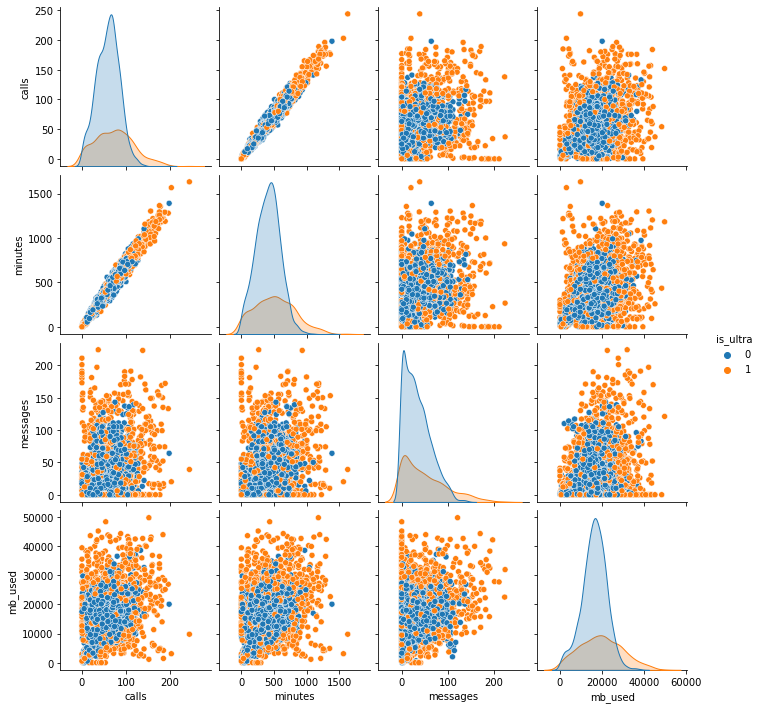

In [4]:
#  Проверим тарифы на мультиколлинеарность
sns.pairplot(df, hue='is_ultra');

In [5]:
# Проверим датасет на сбалансированность тарифов:

df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [6]:
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


<div style="border:solid black 2px; padding: 10px">  

Мы видим, что датасет несбалансирован: пользователи в течение месяца использовали тариф **«Смарт»** в 2.5 раза больше, чем тариф **«Ультра»**

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


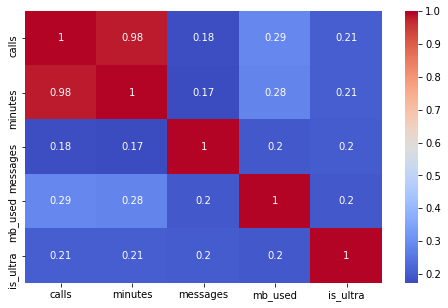

In [7]:
corr_matrix = df.corr()
display(corr_matrix)
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm");

## Разбейте данные на выборки

<div style="border:solid black 2px; padding: 10px">  

Разделим исходные данные на обучающую, валидационную и тестовую выборки в пропорции 3:1:1.  
Для корректного разбиения датасетов применим аргумент **stratify**.

In [8]:
# Сначала выделим из исходных данных тестовую выборку df_test (20%)
df_train_valid, df_test = train_test_split(df, test_size = 0.20, random_state = 12345, stratify = df['is_ultra'])


# Затем выделим из оставшихся данных df_train_valid обучающую и валидационную выборки 
# 20% от исходных данных df = 25% от оставшихся df_train_valid
df_train, df_valid = train_test_split(df_train_valid, test_size = 0.25, \
                                      random_state = 12345, stratify = df_train_valid['is_ultra'])


# Сохраним признаки в отдельных переменных:
features_test = df_test.drop('is_ultra', axis=1)
target_test = df_test['is_ultra']

features_train = df_train.drop('is_ultra', axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop('is_ultra', axis=1)
target_valid = df_valid['is_ultra']

In [9]:
# Проверим корректность разбиения датасетов:

print(f'Тестовая выборка составляет: {df_test.shape[0] / df.shape[0] * 100} % от исходного датасета df')
print(f'Валидационная выборка составляет: {df_valid.shape[0] / df.shape[0] * 100} % от исходного датасета df')
print(f'Валидационная выборка составляет: {df_valid.shape[0] / df_train_valid.shape[0] * 100} % от датасета df_train_valid')

Тестовая выборка составляет: 20.00622277535781 % от исходного датасета df
Валидационная выборка составляет: 20.00622277535781 % от исходного датасета df
Валидационная выборка составляет: 25.009723842862698 % от датасета df_train_valid


## Исследуйте модели

<div style="border:solid black 2px; padding: 10px">  
    
**Исследуем качество разных моделей, меняя гиперпараметры:**  
 - Классифицируем валидационные данные с помощью модели **дерево решений**.
 - А также для последующего построения графиков зависимости значений метрик качества моделей `accuracy`  
 
**От глубины дерева max_depth на обучающей и валидационной выборках создадим следующие списки:**
 - `depth_dt` - с глубиной дерева max_depth, 
 - `accuracy_train_dt` - с качеством модели accuracy (долей правильных ответов) на обучающей выборке,
 - `accuracy_valid_dt` - с качеством модели accuracy (долей правильных ответов) на валидационной выборке
 
**Кратко напишем выводы исследования.**

In [10]:
%%time
# Настроим гиперпараметры модели **дерево решений** и сделаем цикл для max_depth от 1 до 10:
best_model = None
model_depth_four = None  # переменная для модели с depth=4 (для последующего построения дерева решений)
best_depth = 0
best_result = 0
depth_dt = []
accuracy_train_dt = []
accuracy_valid_dt = []
for depth in tqdm(range(1, 13)):
    # создадим модель 'дерево решений' model_dt, указав максимально допустимую глубину дерева max_depth=depth:
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dt.fit(features_train, target_train) # обучим модель на обучающей выборке
    result_train = model_dt.score(features_train, target_train) # посчитаем качество модели на обучающей выборке
    result_valid = model_dt.score(features_valid, target_valid) # посчитаем качество модели на валидационной выборке
    depth_dt.append(depth) # список с глубиной дерева max_depth 
    accuracy_train_dt.append(result_train) # список с качеством модели accuracy на обучающей выборке
    accuracy_valid_dt.append(result_valid) # список с качеством модели accuracy на валидационной выборке
    if result_valid > best_result:
        best_model = model_dt # сохраним наилучшую модель
        best_depth = depth # сохраним наилучшее значение гиперпараметра max_depth на валидационной выборке
        # сохраним наилучшее значение метрики accuracy (доля правильных ответов) на валидационной выборке
        best_result = result_valid
    elif depth == 4:
        model_depth_four = model_dt # сохраним модель с depth=4 (для последующего построения дерева решений)
        
print('Наилучшая модель "дерево решений" на валидационной выборке:', best_model)
print('Глубина дерева наилучшей модели "дерево решений" на валидационной выборке:', best_depth)
print('Accuracy наилучшей модели "дерево решений" на валидационной выборке:', best_result)

100%|██████████| 12/12 [00:00<00:00, 101.81it/s]

Наилучшая модель "дерево решений" на валидационной выборке: DecisionTreeClassifier(max_depth=5, random_state=12345)
Глубина дерева наилучшей модели "дерево решений" на валидационной выборке: 5
Accuracy наилучшей модели "дерево решений" на валидационной выборке: 0.8164852255054432
CPU times: user 113 ms, sys: 3.79 ms, total: 117 ms
Wall time: 122 ms


<div style="border:solid black 2px; padding: 10px">  
    
Наилучшая модель "дерево решений" на валидационной выборке имеет **accuracy** = 0.8164852255054432 при глубине дерева **depth** = 5.

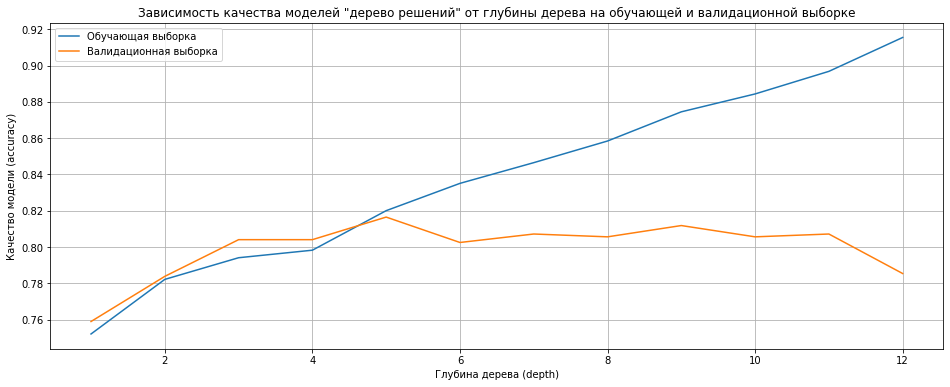

In [11]:
# Построим график зависимости качества моделей "Дерево решений" от глубины дерева на обучающей и валидационной выборке:

plt.figure(figsize=(16, 6))
plt.grid(True)
plt.plot(depth_dt, accuracy_train_dt)
plt.plot(depth_dt, accuracy_valid_dt)
plt.legend(['Обучающая выборка', 'Валидационная выборка'])
plt.xlabel('Глубина дерева (depth)')
plt.ylabel('Качество модели (accuracy)')
plt.title('Зависимость качества моделей "дерево решений" от глубины дерева на обучающей и валидационной выборке')
plt.show()

<div style="border:solid black 2px; padding: 10px">  

На графике видно, что переобучение наступает при глубине дерева в промежутке 4|5, предполагаю, что в качестве лучшего параметра `max_depth` лучше выбрать 4.

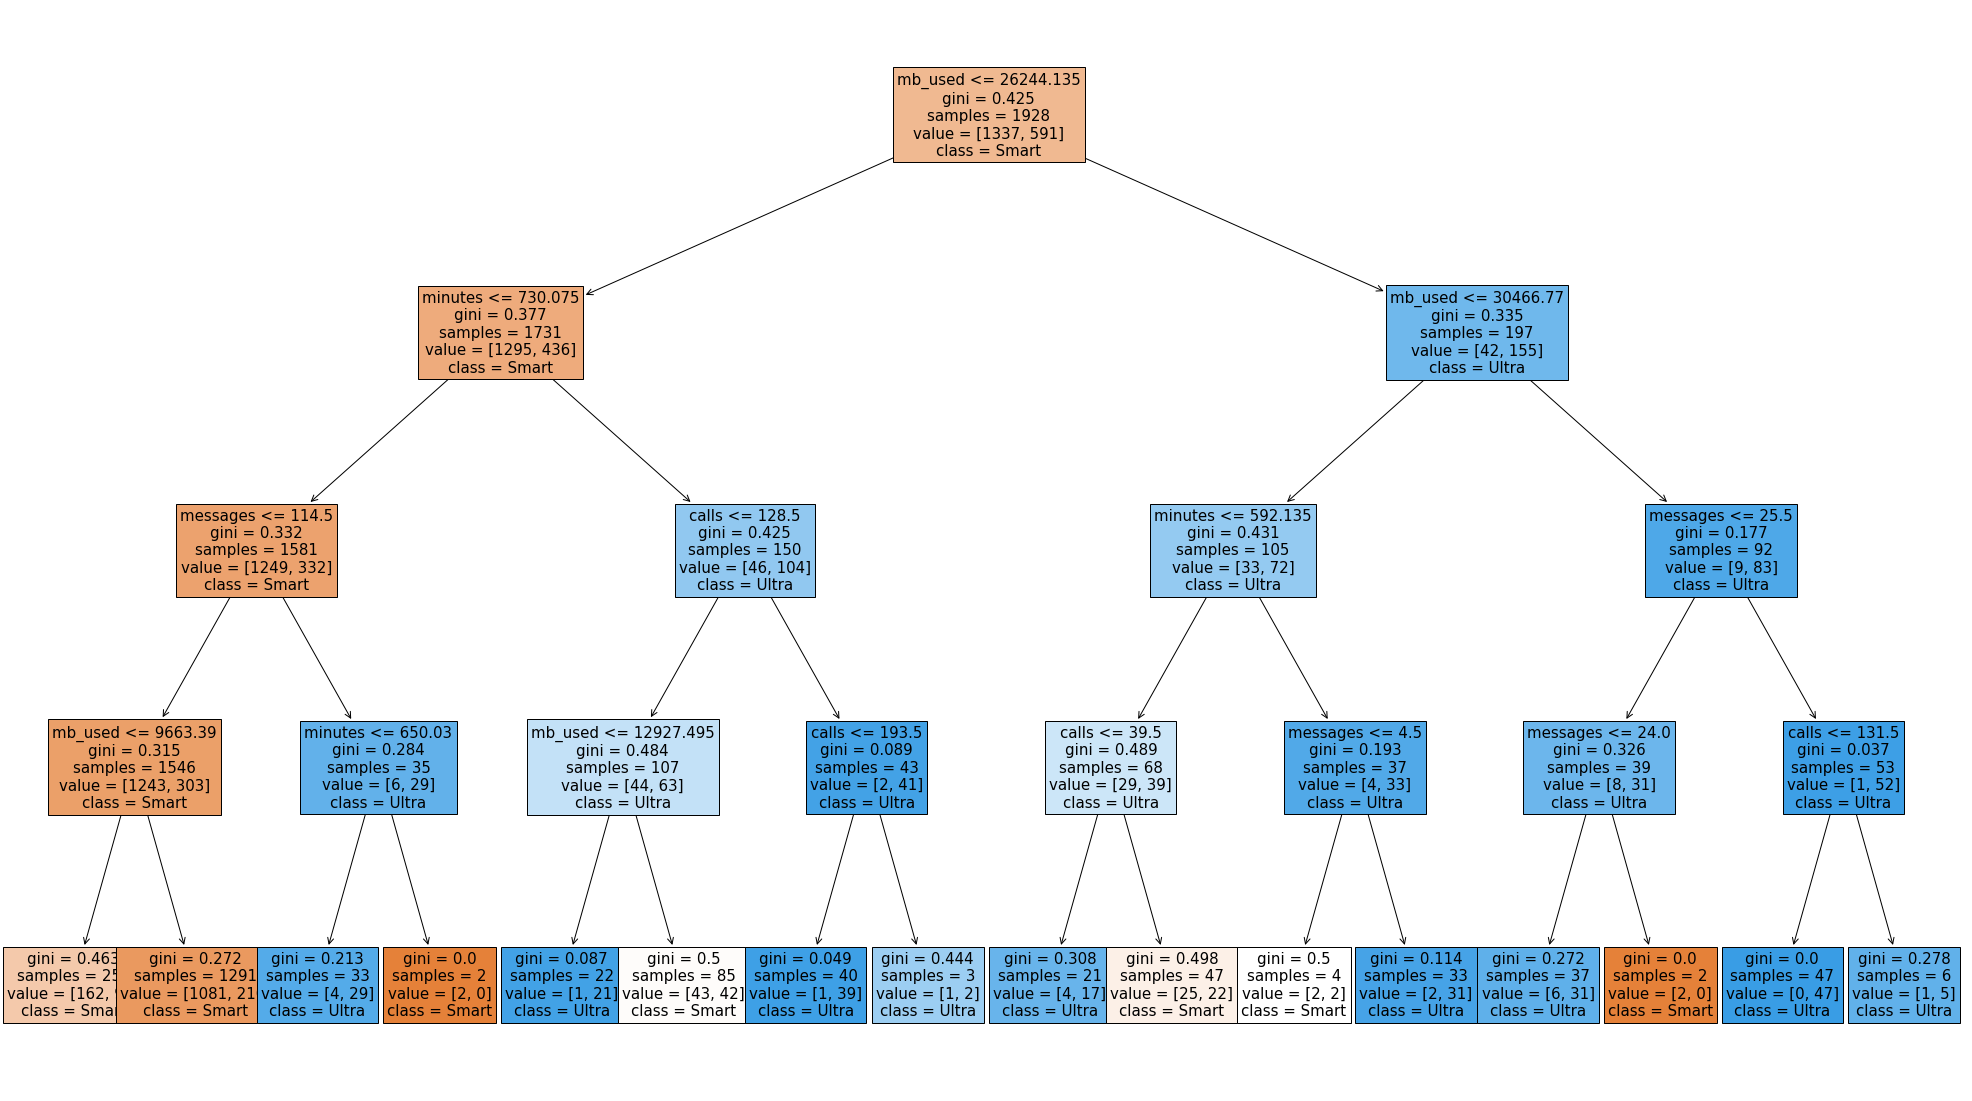

In [12]:
# Построим деревья решений для моделей model_depth_four и best_model при помощи функции plot_tree.
# Дерево решений для модели model_depth_four (модель c depth=4):

fig = plt.figure(figsize=(35,20))
tree.plot_tree(model_depth_four, feature_names=features_train.columns.values, 
                   class_names=['Smart','Ultra'], filled=True, fontsize = 15);


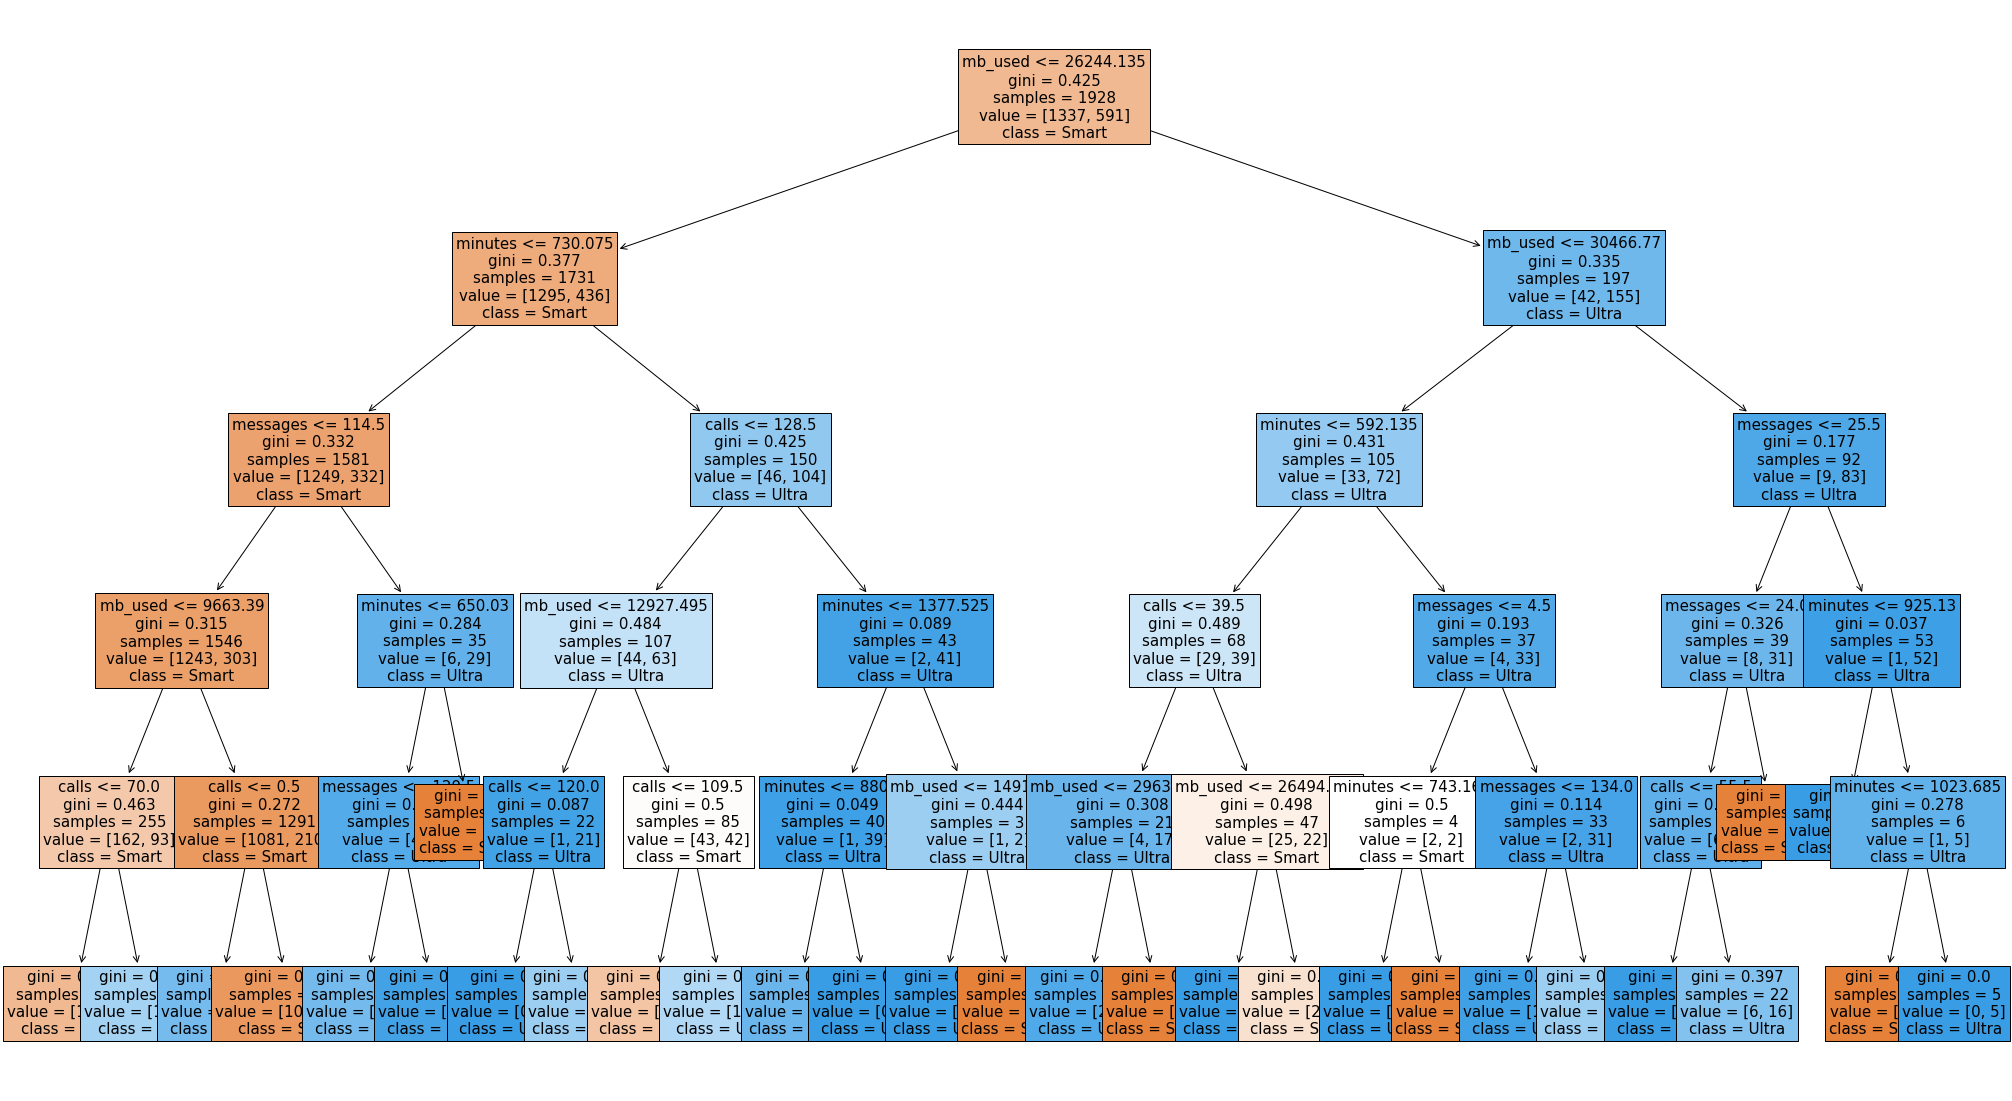

In [13]:
fig = plt.figure(figsize=(35,20))
tree.plot_tree(best_model, feature_names=features_train.columns.values, 
                   class_names=['Smart','Ultra'], filled=True, fontsize = 15);

In [14]:
%%time

# Классифицируем валидационные данные с помощью модели "случайный лес"
# Натсроим гиперпараметры модели "случайный лес" и сделаем цикл для n_estimators и max_depth от 1 до 10:
best_model = None
best_est = 0
best_depth = 0
best_result = 0
for i in range(1, 11):
    for depth in tqdm(range(1, 11),  desc='Loading'):
        # создадим модель "случайный лес" с задаными количеством деревьев и глубиной дерева:
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=i, max_depth=depth)
        model_rf.fit(features_train, target_train) # Обучим модель на обучающей выборке
        result = model_rf.score(features_valid, target_valid) # Посчитаем качество модели на валидационной выборке
        if result > best_result:
            best_model = model_rf # Сохраним лучшую модель
            best_est = i # Сохраним наилучшее значение гиперпараметра n_estimators на валидационной выборке
            best_depth = depth # Сохраним наилучшее значение гиперпараметра max_depth на валидационной выборке
            best_result = result # Сохраним наилучшее значение метрики accuracy на валидационной выборке
        
print('Наилучшая модель "случайный лес" на валидационной выборке:', best_model)
print('Количество деревьев наилучшей модели "случайный лес" на валидационной выборке:', best_est)
print('Глубина дерева наилучшей модели "случайный лес" на валидационной выборке:', best_depth)
print('Accuracy наилучшей модели "случайный лес" на валидационной выборке:', best_result)

Loading: 100%|██████████| 10/10 [00:00<00:00, 34.77it/s]

Наилучшая модель "случайный лес" на валидационной выборке: RandomForestClassifier(max_depth=8, n_estimators=10, random_state=12345)
Количество деревьев наилучшей модели "случайный лес" на валидационной выборке: 10
Глубина дерева наилучшей модели "случайный лес" на валидационной выборке: 8
Accuracy наилучшей модели "случайный лес" на валидационной выборке: 0.8320373250388803
CPU times: user 1.68 s, sys: 29.1 ms, total: 1.71 s
Wall time: 1.77 s


<div style="border:solid black 2px; padding: 10px">  

Наилучшая модель "случайный лес" на валидационной выборке имеет **accuracy** = 0.8320373250388803 при количестве деревьев **est** = 10 и глубине дерева **depth** = 8.

Качество модели "случайный лес" на валидационной выборке выше, чем у модели "дерево решений".

<div style="border:solid black 2px; padding: 10px">  


Для выведения лучшей модели **случайный лес**, а также её гиперпараметров и метрики `accuracy` можно также использовать функционал **GridSearchCV**. Для построения модели используем те же значения гиперпараметров, что и в прошлый раз. **GridSearchCV** применяется к набору данных `df_train_valid`, оставшихся после выделения из исходных данных тестовой выборки df_test (20%). В качестве исходных данных мы можем использовать датафрейм df.

In [15]:
%%time

# Сначала сохраним признаки для датафрейма df_train_valid в отдельных переменных:
features_train_valid = df_train_valid.drop('is_ultra', axis=1)
target_train_valid = df_train_valid['is_ultra']

rf = RandomForestClassifier(random_state=12345) # создадим модель 'случайный лес' rf

parameters = {'n_estimators': range (1, 11),
              'max_depth': range (1, 11)} # отдельно создадим словарь с гиперпараметрами n_estimators и max_depth

# создадим модель model_grid при помощи функционала GridSearchCV с кроссвалидацией cv = 5:
model_grid = GridSearchCV(rf, parameters, cv=5) 

# обучим модель model_grid на обучающей выборке
model_grid.fit(features_train_valid, target_train_valid)

# получаем результаты кроссвалидации
cv_results = model_grid.cv_results_

model_grid.best_estimator_ # наилучшая модель 'случайный лес'

CPU times: user 8.77 s, sys: 59.6 ms, total: 8.83 s
Wall time: 8.84 s


RandomForestClassifier(max_depth=10, n_estimators=10, random_state=12345)

In [16]:
model_grid.best_params_ # Глубина дерева и количество деревьев наилучшей модели "случайный лес"

{'max_depth': 10, 'n_estimators': 10}

In [17]:
model_grid.best_score_ # метрика качества accuracy наилучшей модели 'случайный лес'

0.8020346794605417

<div style="border:solid black 2px; padding: 10px">  

При использовании функционала **GridSearchCV** наилучшая модель "случайный лес" имеет **accuracy** = 0.8020346794605417 при количестве деревьев **est** = 10 и глубине дерева **depth** = 10.

Таким образом, функционал **GridSearchCV** в качестве наилучшей вывел менее качественную модель "случайный лес" по сравнению с использованием цикла for.

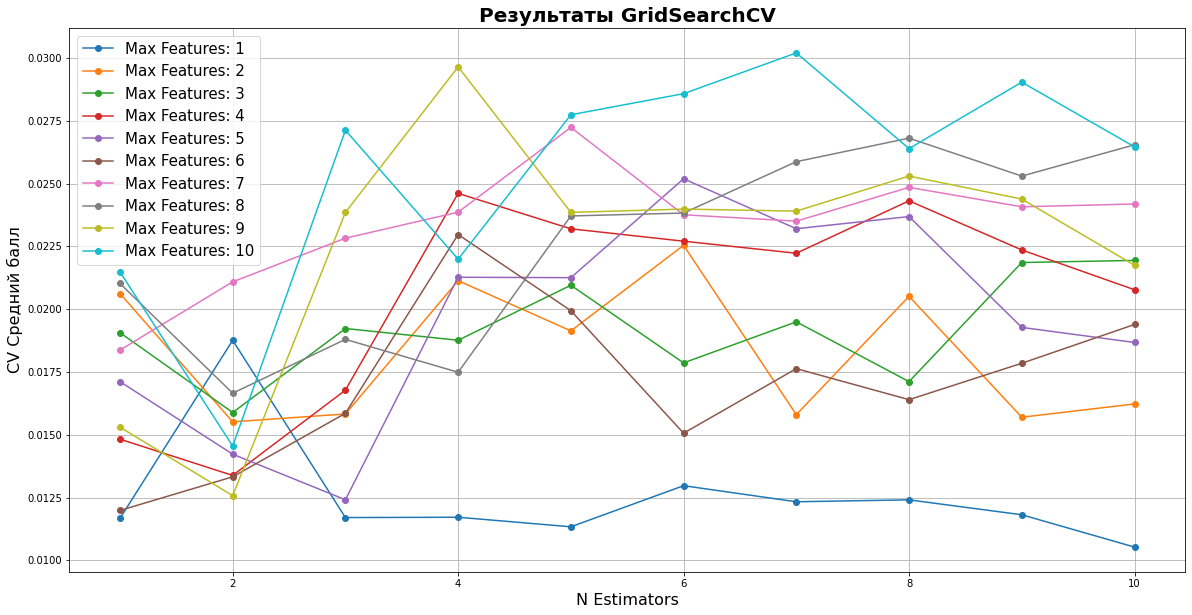

In [18]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # вытаскиваем данные для построения графика
    mean_scores = cv_results['mean_test_score']
    mean_scores = np.array(mean_scores).reshape(len(grid_param_2),len(grid_param_1))

    std_scores = cv_results['std_test_score']
    std_scores = np.array(std_scores).reshape(len(grid_param_2),len(grid_param_1))

    # Результаты поиска на графике
    _, ax = plt.subplots(1,1, figsize=(20,10))
    

    # Param1 - это ось X, Param 2 представлен в виде другой кривой (цветной линии)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, std_scores[idx,:], '-o', label= name_param_2 + ': ' + str(val))
        

    ax.set_title("Результаты GridSearchCV", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Средний балл', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Вызов метода
plot_grid_search(cv_results, parameters['n_estimators'], parameters['max_depth'], 'N Estimators', 'Max Features')

In [19]:
# Классифицируем валидационные данные с помощью модели 'логистическая регрессия'
# (окончание _lr - сокращение от 'logistic regression'):

model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model_lr.fit(features_train, target_train) 
model_lr.score(features_valid, target_valid) 

print("Accuracy модели 'логистическая регрессия' на валидационной выборке:", model_lr.score(features_valid, target_valid))

Accuracy модели 'логистическая регрессия' на валидационной выборке: 0.7558320373250389


<div style="border:solid black 2px; padding: 10px">  

Качество модели "логистическая регрессия" на валидационной выборке ниже, чем у моделей "дерево решений" и "случайный лес".

Итак, на валидационной выборке по качеству лидирует модель "случайный лес".

## Проверьте модель на тестовой выборке

<div style="border:solid black 2px; padding: 10px">  

В пункте 3 **"Исследуйте модели"** мы выяснили, что наилучшей моделью машинного обучения для нашего датасета является "случайный лес". Мы обучали эту модель двумя способами и получили разные значения метрики качества и гиперпараметров:

при помощи цикла **for** (**accuracy** = 0.8320373250388803, **est** = 8, **depth** = 10),  
при помощи функционала **GridSearchCV** (**accuracy** = 0.8020346794605417, **est** = 10, **depth** = 10).    
Функционал **GridSearchCV** в качестве наилучшей вывел менее качественную модель "случайный лес"  
по сравнению с использованием цикла **for**.

Тем не менее, проверим качество модели 'случайный лес' для обоих случаев.

In [20]:
# Проверим на тестовой выборке качество модели 'случайный лес' model_rf, полученной при помощи цикла for:

predictions_test_rf = model_rf.predict(features_test) # найдём предсказания на тестовой выборке
accuracy_rf = accuracy_score(target_test, predictions_test_rf) # вычислим долю правильных ответов
print("Доля правильных ответов accuracy в модели 'случайный лес', полученной с помощью цикла for:", accuracy_rf)

Доля правильных ответов accuracy в модели 'случайный лес', полученной с помощью цикла for: 0.7978227060653188


In [21]:
# Проверим на тестовой выборке качество модели 'случайный лес' model_grid, полученной при помощи функционала GridSearchCV:

predictions_test_grid = model_grid.predict(features_test) # найдём предсказания на тестовой выборке
accuracy_grid = accuracy_score(target_test, predictions_test_grid) # вычислим долю правильных ответов
print("Доля правильных ответов accuracy в модели 'случайный лес', полученной с помощью GridSearchCV:", accuracy_grid)

Доля правильных ответов accuracy в модели 'случайный лес', полученной с помощью GridSearchCV: 0.8180404354587869


<div style="border:solid black 2px; padding: 10px">  

Таким образом, в обоих случаях доля правильных ответов в модели 'случайный лес' превышает 0,75 - изначально поставленное в задании условие.

Доля правильных ответов accuracy, полученных с помощью цикла for, составляет:

0.8320373250388803 - для валидационной выборки,  
0.7978227060653188 - для тестовой выборки. 
Т.е. здесь присутствует эффект переобучения (результат на тестовой выборке хуже, чем на валидационной).

Доля правильных ответов accuracy, полученных с помощью функционала GridSearchCV, составляет:

0.8020346794605417 - для валидационной выборки,  
0.8180404354587869 - для тестовой выборки.  
Использование функционала GridSearchCV для построения модели показало гораздо лучший результат.

In [22]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
model_dt = DecisionTreeClassifier(random_state=12345)
model_dt.fit(features_train, target_train)
# предположим, что у нас есть модель model_dt и данные features_train, target_train
pred = model_dt.predict(features_train)
# матрица ошибок
conf_matrix = confusion_matrix(target_train, pred)
print("Confusion matrix:\n", conf_matrix)
# точность
precision = precision_score(target_train, pred)
print("Precision:", precision)
# полнота
recall = recall_score(target_train, pred)
print("Recall:", recall)
# F1-мера
f1 = f1_score(target_train, pred)
print("F1 Score:", f1)

Confusion matrix:
 [[1337    0]
 [   0  591]]
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


## (бонус) Проверьте модели на адекватность

In [23]:
# Напомним, что датасет df не сбалансирован в таргете:

df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [24]:
# Проверим модели на вменяемость:

model_dummy = DummyClassifier(strategy='most_frequent', random_state=12345) # создадим модель model_dummy
model_dummy.fit(features_train, target_train) # обучим модель model_dummy на обучающей выборке
model_dummy.predict(features_test)
accuracy_dummy = model_dummy.score(features_test, target_test) # посчитаем качество модели на тестовой выборке
print(f'Прогноз самого частого класса ("0"): {accuracy_dummy:.2%}')

Прогноз самого частого класса ("0"): 69.36%


# Общий вывод:

<div style="border:solid black 2px; padding: 10px">  

Проведено исследование с целью предложить пользователям новый тариф **«Смарт»** или **«Ультра»** на основании их поведения.  

Входные данные – данные о поведении клиентов, которые уже перешли на эти тарифы.  

Результаты исследования позволят специалистам выбрать самую качественную модель, которая выберет подходящий тариф.  

Перед проведением исследования были сформулированы несколько гипотез:  

**Гипотеза 1:** самая качественная модель на валидационной выборке - "случайный лес";  
**Гипотеза 2:** максимальное значение метрики качества наилучшей модели (accuracy) больше 0,75.  

На валидационной выборке:

0.8164852255054432 - accuracy модели "дерево решений";
0.8320373250388803 - accuracy модели "случайный лес", построенной при помощи цикла for;
0.8020346794605417 - accuracy модели "случайный лес", построенной при помощи функционала GridSearchCV;
0.7558320373250389 - accuracy модели "логистическая регрессия".
Рекомендация: самой качественной моделью является "случайный лес". Функционал GridSearchCV в качестве наилучшей вывел менее качественную модель "случайный лес" по сравнению с использованием цикла for.

___________________
    
**Гипотеза 2** подтверждена:

Доля правильных ответов **accuracy** модели "случайный лес", полученных с помощью цикла for, составляет:

0.8320373250388803 - для валидационной выборки,
0.7978227060653188 - для тестовой выборки.
Т.е. здесь присутствует эффект переобучения (результат на тестовой выборке хуже, чем на валидационной).

Доля правильных ответов **accuracy** модели "случайный лес", полученных с помощью функционала **GridSearchCV**, составляет:

0.8020346794605417 - для валидационной выборки,
0.8180404354587869 - для тестовой выборки.
Использование функционала **GridSearchCV** для построения модели показало гораздо лучший результат.

Рекомендация: доля правильных ответов для тестовой выборки превышает 0,75 у обеих моделей "случайный лес". Но лучший результат показывает модель, обученаая при помощи Функционала **GridSearchCV**.

**Общие рекомендации:**

Специалистам, которые занимаются исследованием поведения пользователей и планированием увеличения прибыли, можно использовать зависимости из обеих гипотез 1 и 2.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
